## Download data from Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc")

print("Path to dataset files:", path)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import gradio as gr

/home/chris/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Loading Data and Data Preprocessing

In [3]:
print("Loading datasets")

file_paths = {
    'dataset': 'GDSC2-dataset.csv',
    'cell_details': 'Cell_Lines_Details.xlsx',
    'drug_details': 'Compounds-annotation.csv'
}

df_response = pd.read_csv(file_paths['dataset'])
df_response.columns = df_response.columns.str.strip()

try:
    df_cells = pd.read_excel(file_paths['cell_details'], sheet_name='Cell line details', engine='openpyxl')
except:
    df_cells = pd.read_excel(file_paths['cell_details'], sheet_name=0, engine='openpyxl')

raw_id_col = 'COSMIC identifier'
raw_tissue_col = 'GDSC\nTissue descriptor 1'
raw_name_col = 'Sample Name' 

if raw_id_col in df_cells.columns:
    df_cells = df_cells.rename(columns={raw_id_col: 'COSMIC_ID'})
if raw_tissue_col in df_cells.columns:
    df_cells = df_cells.rename(columns={raw_tissue_col: 'GDSC Tissue descriptor 1'})

if raw_name_col in df_cells.columns:
    cell_id_to_name_map = dict(zip(df_cells['COSMIC_ID'], df_cells[raw_name_col]))
else:
    print(f"Cannot find Cell name column '{raw_name_col}'")
    cell_id_to_name_map = {}

try:
    df_drugs_info = pd.read_csv(file_paths['drug_details'])
    df_drugs_info.columns = df_drugs_info.columns.str.strip()
    
    pathway_col = 'TARGET_PATHWAY' if 'TARGET_PATHWAY' in df_drugs_info.columns else 'Target Pathway'
    
    if 'DRUG_NAME' in df_drugs_info.columns:
        drug_name_col = 'DRUG_NAME'
    elif 'Name' in df_drugs_info.columns:
        drug_name_col = 'Name'
    else:
        drug_name_col = None
        print("Cannot find Drug name column 'DRUG_NAME' or 'Name'")

    cols_to_keep = ['DRUG_ID']
    if pathway_col in df_drugs_info.columns: cols_to_keep.append(pathway_col)
    if drug_name_col: cols_to_keep.append(drug_name_col)
    
    df_drugs_subset = df_drugs_info[cols_to_keep].drop_duplicates(subset=['DRUG_ID'])
    
    if drug_name_col:
        drug_id_to_name_map = dict(zip(df_drugs_subset['DRUG_ID'], df_drugs_subset[drug_name_col]))
    else:
        drug_id_to_name_map = {}

except FileNotFoundError:
    print("File not found")
    raise

merged_df = pd.merge(df_response, df_cells[['COSMIC_ID', 'GDSC Tissue descriptor 1']], on='COSMIC_ID', how='inner')
merged_df = pd.merge(merged_df, df_drugs_subset, on='DRUG_ID', how='left')
merged_df[pathway_col] = merged_df[pathway_col].fillna('Unknown')
merged_df = merged_df.dropna(subset=['LN_IC50', 'DRUG_ID', 'GDSC Tissue descriptor 1'])

print(f"Total merged records: {len(merged_df)}")

Loading datasets
Total merged records: 242036


/home/chris/miniconda3/envs/nlp/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Encoding Data
#### Reward(Treat IC50 as a reward)
Reward = 1 - IC50(The lower IC50 get the better reward)

In [4]:
drug_encoder = LabelEncoder()
merged_df['drug_idx'] = drug_encoder.fit_transform(merged_df['DRUG_ID'])
n_drugs = len(drug_encoder.classes_)

pathway_encoder = LabelEncoder()
merged_df['pathway_idx'] = pathway_encoder.fit_transform(merged_df[pathway_col].astype(str))
n_pathways = len(pathway_encoder.classes_)

drug_id_to_pathway_idx = merged_df[['drug_idx', 'pathway_idx']].drop_duplicates().sort_values('drug_idx')
pathway_map_array = np.zeros(n_drugs, dtype=int)
for _, row in drug_id_to_pathway_idx.iterrows():
    pathway_map_array[int(row['drug_idx'])] = int(row['pathway_idx'])
pathway_map_tensor = torch.LongTensor(pathway_map_array).to(device)

cell_encoder = LabelEncoder()
merged_df['cell_idx'] = cell_encoder.fit_transform(merged_df['COSMIC_ID'])
n_cells = len(cell_encoder.classes_)

tissue_encoder = LabelEncoder()
merged_df['tissue_idx'] = tissue_encoder.fit_transform(merged_df['GDSC Tissue descriptor 1'])
n_tissues = len(tissue_encoder.classes_)

scaler = MinMaxScaler()
merged_df['norm_ic50'] = scaler.fit_transform(merged_df[['LN_IC50']])
merged_df['reward'] = 1.0 - merged_df['norm_ic50']

## Two-Tower Architecture Model(Cell and Drug)

In [5]:
class TwoTowerRecommender(nn.Module):
    def __init__(self, n_cells, n_tissues, n_drugs, n_pathways, pathway_map, embedding_dim=32):
        super(TwoTowerRecommender, self).__init__()
        self.pathway_map = pathway_map
        
        self.cell_emb = nn.Embedding(n_cells, embedding_dim)
        self.tissue_emb = nn.Embedding(n_tissues, embedding_dim)
        self.cell_fc = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, embedding_dim)
        )
        
        self.drug_emb = nn.Embedding(n_drugs, embedding_dim)
        self.pathway_emb = nn.Embedding(n_pathways, embedding_dim)
        self.drug_fc = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, embedding_dim)
        )
        
    def forward(self, cell_idx, tissue_idx):
        c_e = self.cell_emb(cell_idx)
        t_e = self.tissue_emb(tissue_idx)
        cell_vector = self.cell_fc(torch.cat([c_e, t_e], dim=1))
        
        all_drug_indices = torch.arange(self.drug_emb.num_embeddings, device=device)
        all_pathway_indices = self.pathway_map[all_drug_indices]
        
        d_e = self.drug_emb(all_drug_indices)
        p_e = self.pathway_emb(all_pathway_indices)
        drug_vectors = self.drug_fc(torch.cat([d_e, p_e], dim=1))
        
        scores = torch.matmul(cell_vector, drug_vectors.t())
        return scores

## Training Loop

In [6]:
train_df, test_df = np.split(merged_df.sample(frac=1, random_state=42), [int(.8*len(merged_df))])

def create_loader(df, batch_size=128):
    dataset = torch.utils.data.TensorDataset(
        torch.LongTensor(df['cell_idx'].values),
        torch.LongTensor(df['tissue_idx'].values),
        torch.LongTensor(df['drug_idx'].values),
        torch.FloatTensor(df['reward'].values)
    )
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_loader(train_df)
test_loader = create_loader(test_df, batch_size=1000)

model = TwoTowerRecommender(n_cells, n_tissues, n_drugs, n_pathways, pathway_map_tensor).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

history_loss = []
history_reward = []

EPOCHS = 10
print(f"Start training the Two-Tower model ({EPOCHS} Epochs)")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_reward = 0
    
    for bc, bt, bd, br in train_loader:
        bc, bt, bd, br = bc.to(device), bt.to(device), bd.to(device), br.to(device)
        
        optimizer.zero_grad()
        all_scores = model(bc, bt)
        preds = all_scores.gather(1, bd.unsqueeze(1)).squeeze(1)
        
        loss = criterion(preds, br)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_reward += br.mean().item()
        
    avg_loss = total_loss / len(train_loader)
    avg_reward = total_reward / len(train_loader)
    history_loss.append(avg_loss)
    history_reward.append(avg_reward)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Avg Reward: {avg_reward:.4f}")

/home/chris/miniconda3/envs/nlp/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Start training the Two-Tower model (10 Epochs)
Epoch 1/10 | Loss: 0.0071 | Avg Reward: 0.4874
Epoch 2/10 | Loss: 0.0029 | Avg Reward: 0.4874
Epoch 3/10 | Loss: 0.0027 | Avg Reward: 0.4874
Epoch 4/10 | Loss: 0.0026 | Avg Reward: 0.4874
Epoch 5/10 | Loss: 0.0025 | Avg Reward: 0.4874
Epoch 6/10 | Loss: 0.0024 | Avg Reward: 0.4874
Epoch 7/10 | Loss: 0.0023 | Avg Reward: 0.4874
Epoch 8/10 | Loss: 0.0022 | Avg Reward: 0.4874
Epoch 9/10 | Loss: 0.0022 | Avg Reward: 0.4874
Epoch 10/10 | Loss: 0.0021 | Avg Reward: 0.4874


## Plot training Curve

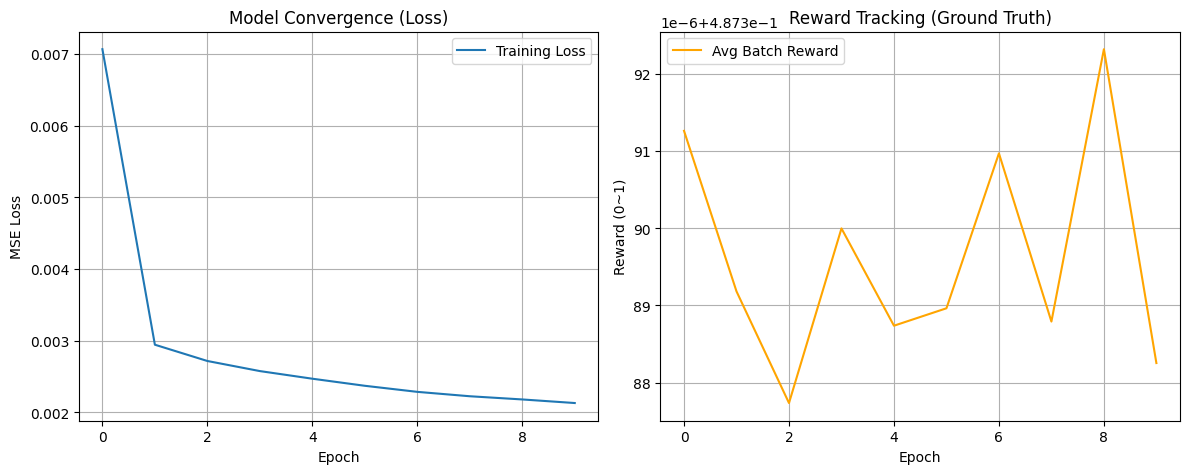

In [7]:
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history_loss, label='Training Loss')
plt.title("Model Convergence (Loss)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()

# Reward Curve
plt.subplot(1, 2, 2)
plt.plot(history_reward, color='orange', label='Avg Batch Reward')
plt.title("Reward Tracking (Ground Truth)")
plt.xlabel("Epoch")
plt.ylabel("Reward (0~1)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Baseline Comparison
Compare with random choice and mean choice

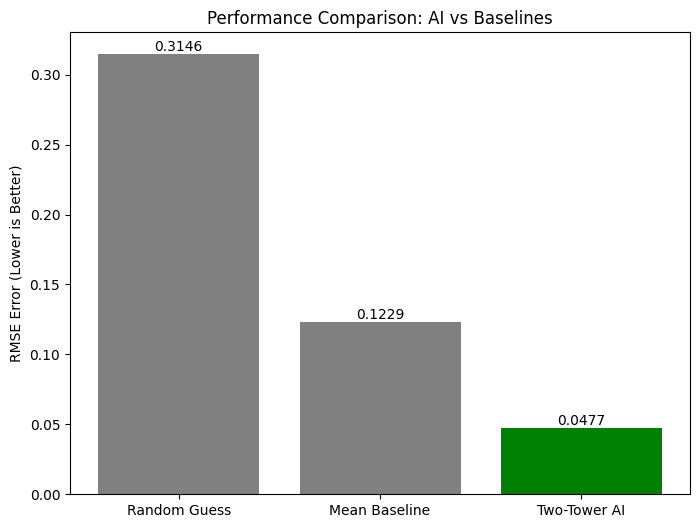

Model RMSE: 0.0477 (Baseline Mean: 0.1229)


In [8]:
model.eval()

y_true = []
y_pred_model = []

with torch.no_grad():
    for bc, bt, bd, br in test_loader:
        bc, bt, bd = bc.to(device), bt.to(device), bd.to(device)
        all_scores = model(bc, bt)
        batch_preds = all_scores.gather(1, bd.unsqueeze(1)).squeeze(1)
        y_true.extend(br.cpu().numpy())
        y_pred_model.extend(batch_preds.cpu().numpy())

y_true = np.array(y_true)
y_pred_model = np.array(y_pred_model)

rmse_model = np.sqrt(mean_squared_error(y_true, y_pred_model))
rmse_random = np.sqrt(mean_squared_error(y_true, np.random.rand(len(y_true))))
rmse_mean = np.sqrt(mean_squared_error(y_true, np.full(len(y_true), train_df['reward'].mean())))

plt.figure(figsize=(8, 6))
methods = ['Random Guess', 'Mean Baseline', 'Two-Tower AI']
errors = [rmse_random, rmse_mean, rmse_model]
bars = plt.bar(methods, errors, color=['gray', 'gray', 'green'])
plt.ylabel('RMSE Error (Lower is Better)')
plt.title('Performance Comparison: AI vs Baselines')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.4f}", ha='center', va='bottom')
plt.show()

print(f"Model RMSE: {rmse_model:.4f} (Baseline Mean: {rmse_mean:.4f})")

## Recommendation Simulation

In [9]:
print("Results of Simulated Recommendations (Top 3 Drugs)")
test_samples = merged_df.sample(3)

with torch.no_grad():
    for i, row in test_samples.iterrows():
        c_idx = torch.LongTensor([row['cell_idx']]).to(device)
        t_idx = torch.LongTensor([row['tissue_idx']]).to(device)
        
        original_id = row['COSMIC_ID']
        original_tissue = row['GDSC Tissue descriptor 1']
        
        cell_name = cell_id_to_name_map.get(original_id, "Unknown Cell")
        
        q_values = model(c_idx, t_idx)
        top_k = torch.topk(q_values, 3)
        top_indices = top_k.indices[0].cpu().numpy()
        top_scores = top_k.values[0].cpu().numpy()
        
        print(f"\n[Patient Case] Cell Line: {cell_name:<15} (ID: {original_id}) | Tissue: {original_tissue}")
        print("  Recommended Treatments:")
        
        for rank, (d_idx, score) in enumerate(zip(top_indices, top_scores)):
            drug_original_id = drug_encoder.inverse_transform([d_idx])[0]
            real_drug_name = drug_id_to_name_map.get(drug_original_id, f"Drug-{drug_original_id}")
            
            pathway_idx = pathway_map_array[d_idx]
            pathway_name = pathway_encoder.inverse_transform([pathway_idx])[0]
            
            print(f"  {rank+1}. {real_drug_name:<20} (ID: {drug_original_id}) | Score: {score:.4f} | Pathway: {pathway_name}")

Results of Simulated Recommendations (Top 3 Drugs)

[Patient Case] Cell Line: C2BBe1          (ID: 910700) | Tissue: large_intestine
  Recommended Treatments:
  1. Romidepsin           (ID: 1817) | Score: 0.8097 | Pathway: Chromatin histone acetylation
  2. Bortezomib           (ID: 1191) | Score: 0.7905 | Pathway: Protein stability and degradation
  3. Sepantronium bromide (ID: 1941) | Score: 0.7736 | Pathway: Apoptosis regulation

[Patient Case] Cell Line: NCI-H1993       (ID: 908476) | Tissue: lung_NSCLC
  Recommended Treatments:
  1. Romidepsin           (ID: 1817) | Score: 0.8638 | Pathway: Chromatin histone acetylation
  2. Docetaxel            (ID: 1007) | Score: 0.8502 | Pathway: Mitosis
  3. Dactinomycin         (ID: 1911) | Score: 0.8487 | Pathway: Other

[Patient Case] Cell Line: GDM-1           (ID: 906870) | Tissue: leukemia
  Recommended Treatments:
  1. Dactinomycin         (ID: 1911) | Score: 0.8658 | Pathway: Other
  2. Docetaxel            (ID: 1007) | Score: 0.8609 |

## Frontend Interface

In [10]:

def get_no_data_outputs(message="No Data"):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.text(0.5, 0.5, message, 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=20, color='gray', transform=ax.transAxes)
    ax.set_xticks([]) 
    ax.set_yticks([])
    plt.tight_layout()
    plt.close()

    df_empty = pd.DataFrame([["No Data", "No Data", "No Data", "No Data", "No Data"]], 
                            columns=["Rank", "Drug Name", "Score (Efficacy)", "Target Pathway", "Drug ID"])
    
    return fig, df_empty

def agent_recommend(input_cell_id_str):
    try:
        if not input_cell_id_str.strip().isdigit():
             return get_no_data_outputs("Invalid Input (Please enter a number)")
             
        target_id = int(input_cell_id_str.strip())
        valid_ids = set(merged_df['COSMIC_ID'].unique())
        
        if target_id not in valid_ids:
            return get_no_data_outputs(f"No Data Found for Cell ID: {target_id}")
            
        cell_name = cell_id_to_name_map.get(target_id, "Unknown Cell")
        
        subset = merged_df[merged_df['COSMIC_ID'] == target_id]
        target_tissue = subset.iloc[0]['GDSC Tissue descriptor 1']
        
        c_idx = torch.LongTensor(cell_encoder.transform([target_id])).to(device)
        t_idx = torch.LongTensor(tissue_encoder.transform([target_tissue])).to(device)
        
        model.eval()
        with torch.no_grad():
            q_values = model(c_idx, t_idx)
            
            top_k = torch.topk(q_values, 10)
            top_indices = top_k.indices[0].cpu().numpy()
            top_scores = top_k.values[0].cpu().numpy()
        
        results = []
        plot_names = []
        plot_scores = []
        
        for rank, (d_idx, score) in enumerate(zip(top_indices, top_scores)):
            drug_original_id = drug_encoder.inverse_transform([d_idx])[0]
            real_drug_name = drug_id_to_name_map.get(drug_original_id, f"Drug-{drug_original_id}")
            
            pathway_idx = pathway_map_array[d_idx]
            pathway_name = pathway_encoder.inverse_transform([pathway_idx])[0]
            
            results.append([rank+1, real_drug_name, score, pathway_name, drug_original_id])
            
            if rank < 5:
                unique_plot_name = f"{real_drug_name} (ID: {drug_original_id})"
                plot_names.append(unique_plot_name) 
                plot_scores.append(score)
        
        df_result = pd.DataFrame(results, columns=["Rank", "Drug Name", "Score (Efficacy)", "Target Pathway", "Drug ID"])
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        bars = ax.barh(plot_names[::-1], plot_scores[::-1], color='#2ca02c') 
        
        ax.set_xlabel('Predicted Efficacy Score (Reward)')
        ax.set_title(f'Top 5 Recommended Treatments for Cell: {cell_name} ({target_tissue})')
        ax.set_xlim(0, 1.1) 
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        
        for bar in bars:
            label_x_pos = bar.get_width() + 0.01
            ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', va='center')
        
        plt.tight_layout()
        plt.close() 
        
        return fig, df_result
        
    except Exception as e:
        import traceback
        traceback.print_exc()
        return get_no_data_outputs(f"System Error: {str(e)}")

sample_ids = merged_df['COSMIC_ID'].unique()[:5].tolist()
example_str = ", ".join([str(x) for x in sample_ids])

with gr.Blocks(title="AI Precision Medicine Agent") as demo:
    gr.Markdown("# AI Precision Medicine: Personalized Drug Recommender(Based on Deep Contextual Bandits)")
    
    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### 1. Patient Case Input")
            input_text = gr.Textbox(label="Enter Cell Line ID (COSMIC ID)", placeholder="e.g., 906826")
            gr.Markdown(f"**Try these valid IDs:** {example_str} ...")
            run_btn = gr.Button("Generate Recommendation", variant="primary")
            
        with gr.Column(scale=2):
            gr.Markdown("### 2. Visualization & Analysis")
            output_plot = gr.Plot(label="Top 5 Efficacy Analysis")
            output_df = gr.Dataframe(label="Detailed Recommendation List", headers=["Rank", "Drug Name", "Score", "Pathway", "ID"])

    run_btn.click(fn=agent_recommend, inputs=input_text, outputs=[output_plot, output_df])

print("Launching Gradio Interface")
demo.launch(share=True)

Launching Gradio Interface
* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://fd1ea85946b62e8856.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
